In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from DTW import _traceback, dtwPlotTwoWay
from tqdm import tqdm
from tslearn.barycenters import softdtw_barycenter

In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(list(np.pad(piece, (0, N), 'constant')))
    return pieces_padded

In [4]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()


    return [dis12/dis21, A0/A1]

In [11]:
def extract_(templates, h, d):
    features = []
    idxs = []

    for cnt, template in tqdm(enumerate(templates)):
        feature = get_features(template, h, d)
        if feature is not None:
            idxs.append(cnt)
            features.append(feature)

    return np.array(features), np.array(idxs)


In [12]:
def get_pieces(signals, labels, alpha):

    all_pieces = []
    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)
        all_pieces.append(pieces)

    return all_pieces

In [13]:
if __name__=='__main__':
    import scipy.io
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    # labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    # 2matlab
    # npy_paths = []
    # scipy.io.savemat('D:\PHD\Research\SourceCodes\TTW-master\data\labels_0_train.mat', {'your_variable_name': labels_0_train})
    # scipy.io.savemat('D:\PHD\Research\SourceCodes\TTW-master\data\labels_0_test.mat', {'your_variable_name': labels_0_test})
    # scipy.io.savemat('D:\PHD\Research\SourceCodes\TTW-master\data\signals_0_train.mat', {'your_variable_name': signals_0_train})
    # scipy.io.savemat('D:\PHD\Research\SourceCodes\TTW-master\data\signals_0_test.mat', {'your_variable_name': signals_0_test})

    # from matlab
    paths = ['D:\PHD\Research\SourceCodes\TTW-master\cell_templates_ttw_train.mat',
             'D:\PHD\Research\SourceCodes\TTW-master\cell_templates_ttw_test.mat',
             'D:\PHD\Research\SourceCodes\TTW-master\cell_templates_fltw_train.mat',
             'D:\PHD\Research\SourceCodes\TTW-master\cell_templates_fltw_test.mat',]
    cell_templates_ttw_train = scipy.io.loadmat(paths[0])['cell_templates_ttw_train']
    cell_templates_ttw_test = scipy.io.loadmat(paths[1])['cell_templates_ttw_test']
    cell_templates_fltw_train = scipy.io.loadmat(paths[2])['cell_templates_fltw_train']
    cell_templates_fltw_test = scipy.io.loadmat(paths[3])['cell_templates_fltw_test']

    def get_std_templates(cell_templates):
        templates = [template.reshape(-1) for template in cell_templates[0]]
        return templates

    ttw_templates_train = get_std_templates(cell_templates_ttw_train)
    ttw_templates_test = get_std_templates(cell_templates_ttw_test)
    fltw_templates_train = get_std_templates(cell_templates_fltw_train)
    fltw_templates_test = get_std_templates(cell_templates_fltw_test)

    ttw_features_train, ttw_idxs_train = extract_(ttw_templates_train, 0.1,0.15)
    ttw_features_test, ttw_idxs_test = extract_(ttw_templates_test, 0.12,0.12)

    fltw_features_train, fltw_idxs_train = extract_(fltw_templates_train, 0.1,0.15)
    fltw_features_test, fltw_test = extract_(fltw_templates_test, 0.12,0.12)


(4718, 1000) (2822, 6)


4718it [00:00, 15340.38it/s]
2822it [00:00, 14482.96it/s]
4718it [00:00, 15489.38it/s]
2822it [00:00, 12622.69it/s]


In [18]:
ttw_features_train.shape, ttw_idxs_train.shape, ttw_features_test.shape, ttw_idxs_test.shape

((4718, 2), (4718,), (2822, 2), (2822,))

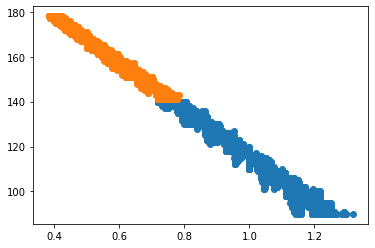

1.523066440967219


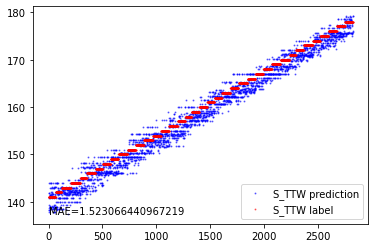

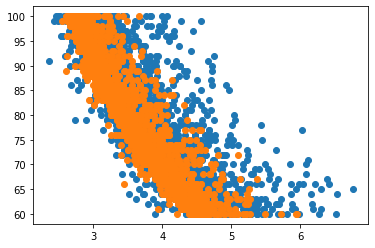

4.2831447428667575


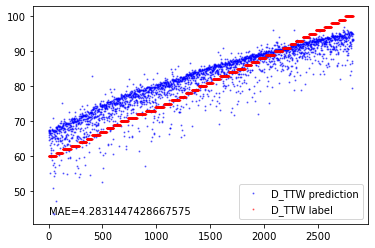

In [21]:
from sklearn.linear_model import LinearRegression as LR

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(ttw_features_train[:, 0],ttw_features_test[:, 0],labels_0_train[ttw_idxs_train, 4],labels_0_test[ttw_idxs_test, 4],'S_TTW')
plot_plot(ttw_features_train[:, 1],ttw_features_test[:, 1],labels_0_train[ttw_idxs_train, 5],labels_0_test[ttw_idxs_test, 5],'D_TTW')


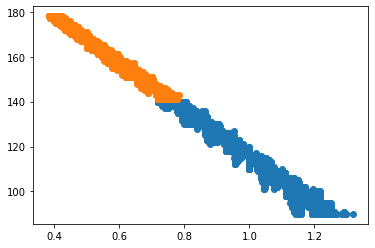

1.523066440967219


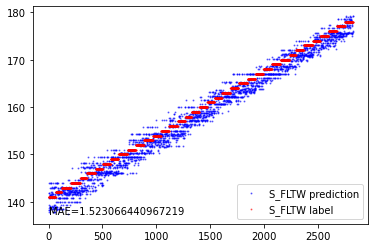

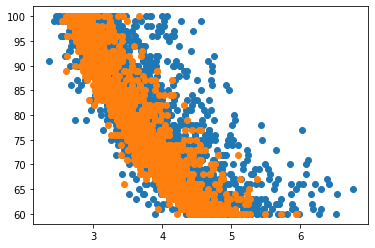

4.283098629040339


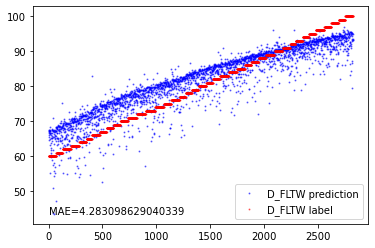

In [22]:
plot_plot(fltw_features_train[:, 0],fltw_features_test[:, 0],labels_0_train[fltw_idxs_train, 4],labels_0_test[fltw_test, 4],'S_FLTW')
plot_plot(fltw_features_train[:, 1],fltw_features_test[:, 1],labels_0_train[fltw_idxs_train, 5],labels_0_test[fltw_test, 5],'D_FLTW')

In [20]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()